<font size="8"> **Using crabeater observations to create masks using ACCESS-OM2-01 grids** </font>  
In this notebook, we will load the clean crabeater observations to create a mask using the ACCESS-OM2-01 grids (ocean and velocity grids). We will use the crabeater observations mask to extract relevant environmental variables from the ACCESS-OM2-01 model.  
  
The clean crabeater observations dataset includes two types of records: `HUMAN_OBSERVATION` and `MACHINE_OBSERVATION`. The first type involves one or more people searching for crabeater seals and recording their presence. The second type comes from instruments, such as GPS tags. For this project, we will only use `HUMAN_OBSERVATION` records.  
  
Given that crabeater seal data came from different sources and not all sources provide enough information to calculate abundance, we will transform crabeater records to presence only. Further, we will reduce crabeater sighting records to one record per month per cell in the ACCESS-OM2-01 grid. This means that we will assign a value of `1` to a grid cell where crabeater seals have reported, regardless of the amount of individuals or sightings reported at that specific grid cell within a particular month.

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [3]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

# Loading other relevant libraries

In [4]:
from dask.distributed import Client
#Accessing model data
import cosima_cookbook as cc
#Useful functions
import UsefulFunctions as uf
#Dealing with data
import xarray as xr
import pandas as pd
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt

# Paralellising work 

In [5]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33677/status,
Dashboard: /proxy/33677/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40841,Workers: 7
Dashboard: /proxy/33677/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:36283,Total threads: 2
Dashboard: /proxy/40199/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:40231,


# Loading crabeater seal observations
This is the dataset that includes the MEASO sector category. See [03_Adding_MEASO_bio_data]('03_Adding_MEASO_bio_data.ipynb') notebook for more details. We will only keep crabeater seals observations that are categorised as `HUMAN_OBSERVATION` in the `basis_record` column.  
  
We will add two columns: `year` and `month` to identify unique monthly crabeater observations at a grid cell.

In [42]:
#Loading dataset as pandas data frame
crabeaters = pd.read_csv('../Cleaned_Data/All_sources_clean_data_MEASO.csv', 
                         index_col = 0)

#Removing columns that are not needed
crabeaters = crabeaters.drop(columns = ['geometry', 'index_right', 'name', 'fill', 'LongName'])

#Creating new date column, which will only include the year and month the observation occurred
crabeaters['date'] = crabeaters.apply(lambda x: f'{x.year}-{str(x.month).zfill(2)}', axis = 1)

#Keeping human observation records only
crabeaters = crabeaters[crabeaters.basis_record == "HUMAN_OBSERVATION"]

#Checking results
crabeaters.head()

,event_date,latitude,longitude,number_individuals,basis_record,year,month,season_year,life_stage,decade,sector,zone,date
0,2019-03-09T00:00:00Z,-64.9028,-62.8643,1,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,East Pacific,Antarctic,2019-03
1,2019-03-13T00:00:00Z,-65.1413,-64.1443,10,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,East Pacific,Antarctic,2019-03
2,2019-03-15T00:00:00Z,-65.1402,-64.0595,6,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,East Pacific,Antarctic,2019-03
3,2019-03-15T00:00:00Z,-65.0977,-63.9802,6,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,East Pacific,Antarctic,2019-03
4,2019-03-14T00:00:00Z,-65.3383,-64.1300,65,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,East Pacific,Antarctic,2019-03


## Rearranging columns in crabeater data
We will move the newly created `date` column next to the `event_date` column. This way it is easier to inspect that the new column contains the correct information.

In [43]:
#Getting the names of columns in crabeater dataset
cols = crabeaters.columns.tolist()

#Re-arranging column names so date appears next to event date
cols = cols[0:1] + cols[-1:] + cols[1:-1]

#Applying to crabeater dataset
crabeaters = crabeaters[cols]

#Checking results
crabeaters

,event_date,date,latitude,longitude,number_individuals,basis_record,year,month,season_year,life_stage,decade,sector,zone
0,2019-03-09T00:00:00Z,2019-03,-64.9028,-62.8643,1,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,East Pacific,Antarctic
1,2019-03-13T00:00:00Z,2019-03,-65.1413,-64.1443,10,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,East Pacific,Antarctic
2,2019-03-15T00:00:00Z,2019-03,-65.1402,-64.0595,6,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,East Pacific,Antarctic
3,2019-03-15T00:00:00Z,2019-03,-65.0977,-63.9802,6,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,East Pacific,Antarctic
4,2019-03-14T00:00:00Z,2019-03,-65.3383,-64.1300,65,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,East Pacific,Antarctic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154792,2006-02-19T13:00:00Z,2006-02,-67.0779,69.9942,1,HUMAN_OBSERVATION,2006,2,summer,moulting,2000,Central Indian,Antarctic
154793,2006-01-30T13:00:00Z,2006-01,-67.9639,40.7485,1,HUMAN_OBSERVATION,2006,1,summer,moulting,2000,Central Indian,Antarctic
154794,2006-02-19T13:00:00Z,2006-02,-67.0892,69.9950,2,HUMAN_OBSERVATION,2006,2,summer,moulting,2000,Central Indian,Antarctic
154795,2006-02-19T13:00:00Z,2006-02,-67.1395,69.9984,1,HUMAN_OBSERVATION,2006,2,summer,moulting,2000,Central Indian,Antarctic


# Loading ACCESS-OM2-01 grids
The ACCESS-OM2-01 model uses two grid cells, which vary sligthly (less than 1/100 of a degree). Model outputs for water velocity (`u` and `v`) use a different grid to all other outputs available in the ACCESS-OM2-01 model. We will load these two grids to identify our unique monthly crabeater seal observations and create our masks.  
  
To access model ouptuts, weneed to create a new `cosima cookbook` session. We will use the area of the grid cells (`area_t`) and zonal velocity (`u`) outputs as samples of the two grids used in the model.

In [6]:
#Creating new COSIMA cookbook session
session = cc.database.create_session()

#Accessing the area of grid and keeping data for the Southern Ocean only
grid_all = cc.querying.getvar('01deg_jra55v140_iaf_cycle4', 'area_t', session, n = 1).sel(yt_ocean = slice(-80, -45))
#Correcting longitude values to keep them between +/- 180
grid_all = uf.corrlong(grid_all)

#Accessing zonal velocity and keeping data for the Southern Ocean only
grid_vel = cc.querying.getvar('01deg_jra55v140_iaf_cycle4', 'u', session, n = 1).sel(yu_ocean = slice(-80, -45))
#Correcting longitude values to keep them between +/- 180
grid_vel = uf.corrlong(grid_vel)
#Keeping first time step and first depth level as a sample. The grid is the same regardless of time and depth.
grid_vel = grid_vel.isel(st_ocean = 0).drop('st_ocean').drop('time').squeeze('time')

# Identifying unique crabeater observations per month per grid cell
In this step, we will identify the model grid cell within which a crabeater seal was reported. We will then add the the grid cell coordinates to the crabeater seal dataframe (`xt_ocean`, `yt_ocean`, `xu_ocean`, and `yu_ocean`, depending on the grid).  
  
This step may take a couple of minutes to run.

In [44]:
#Adding grid cell coordinates to data frame - This will locate the values of longitude and latitude for the grid cell where a crabeater was sighted.
#Coordinate values are rounded to three decimal places
#First grid
crabeaters['yt_ocean'] = crabeaters.apply(lambda i: np.around(grid_all.sel(xt_ocean = i.longitude, yt_ocean = i.latitude, method = 'nearest').yt_ocean.values, 3), axis = 1)
crabeaters['xt_ocean'] = crabeaters.apply(lambda i: np.around(grid_all.sel(xt_ocean = i.longitude, yt_ocean = i.latitude, method = 'nearest').xt_ocean.values, 3), axis = 1)
#second grid
crabeaters['yu_ocean'] = crabeaters.apply(lambda i: np.around(grid_vel.sel(xu_ocean = i.longitude, yu_ocean = i.latitude, method = 'nearest').yu_ocean.values, 3), axis = 1)
crabeaters['xu_ocean'] = crabeaters.apply(lambda i: np.around(grid_vel.sel(xu_ocean = i.longitude, yu_ocean = i.latitude, method = 'nearest').xu_ocean.values, 3), axis = 1)

We will reorganise the columns to keep all spatial information together.

In [45]:
#Reorganising columns
#Getting the names of columns in crabeater dataset
cols = crabeaters.columns.tolist()
#Re-arranging column names so date appears next to event date
cols = cols[0:4] + cols[6:8] + cols[-4:] + cols[8:-4]

#Applying to crabeater dataset
crabeaters = crabeaters[cols]
#Checking results
crabeaters

,event_date,date,latitude,longitude,year,month,yt_ocean,xt_ocean,yu_ocean,xu_ocean,season_year,life_stage,decade,sector,zone
0,2019-03-09T00:00:00Z,2019-03,-64.9028,-62.8643,2019,3,-64.888,-62.85,-64.910,-62.9,autumn,in-between,2010,East Pacific,Antarctic
1,2019-03-13T00:00:00Z,2019-03,-65.1413,-64.1443,2019,3,-65.142,-64.15,-65.121,-64.1,autumn,in-between,2010,East Pacific,Antarctic
2,2019-03-15T00:00:00Z,2019-03,-65.1402,-64.0595,2019,3,-65.142,-64.05,-65.121,-64.1,autumn,in-between,2010,East Pacific,Antarctic
3,2019-03-15T00:00:00Z,2019-03,-65.0977,-63.9802,2019,3,-65.100,-63.95,-65.079,-64.0,autumn,in-between,2010,East Pacific,Antarctic
4,2019-03-14T00:00:00Z,2019-03,-65.3383,-64.1300,2019,3,-65.353,-64.15,-65.332,-64.1,autumn,in-between,2010,East Pacific,Antarctic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154792,2006-02-19T13:00:00Z,2006-02,-67.0779,69.9942,2006,2,-67.085,69.95,-67.064,70.0,summer,moulting,2000,Central Indian,Antarctic
154793,2006-01-30T13:00:00Z,2006-01,-67.9639,40.7485,2006,1,-67.972,40.75,-67.951,40.7,summer,moulting,2000,Central Indian,Antarctic
154794,2006-02-19T13:00:00Z,2006-02,-67.0892,69.9950,2006,2,-67.085,69.95,-67.106,70.0,summer,moulting,2000,Central Indian,Antarctic
154795,2006-02-19T13:00:00Z,2006-02,-67.1395,69.9984,2006,2,-67.127,69.95,-67.149,70.0,summer,moulting,2000,Central Indian,Antarctic


Using the the `duplicated` method from `pandas`, we will identify duplicate records using all columns except `event_date`, `number_individuals`, and the original coordinates where a sighting was reported. 

In [46]:
#Getting all column names for crabeaters observation dataset
cols = crabeaters.columns.to_list()
#Keeeping column names to be used when identifying duplicates
cols = cols[1:2] + cols[4:]

#Checking columns to be used in duplicate identification
cols

['date',
 'year',
 'month',
 'yt_ocean',
 'xt_ocean',
 'yu_ocean',
 'xu_ocean',
 'season_year',
 'life_stage',
 'decade',
 'sector',
 'zone']

In [53]:
# Add a column identifying duplicate sightings per cell per month
crabeaters['dup'] = crabeaters.duplicated(subset = cols)

#Keeping unique records (i.e., dup column is False)
crabeaters = crabeaters[crabeaters.dup == False]
#Checking results
crabeaters

,event_date,date,latitude,longitude,year,month,yt_ocean,xt_ocean,yu_ocean,xu_ocean,season_year,life_stage,decade,sector,zone,dup
0,2019-03-09T00:00:00Z,2019-03,-64.9028,-62.8643,2019,3,-64.888,-62.85,-64.910,-62.9,autumn,in-between,2010,East Pacific,Antarctic,False
1,2019-03-13T00:00:00Z,2019-03,-65.1413,-64.1443,2019,3,-65.142,-64.15,-65.121,-64.1,autumn,in-between,2010,East Pacific,Antarctic,False
2,2019-03-15T00:00:00Z,2019-03,-65.1402,-64.0595,2019,3,-65.142,-64.05,-65.121,-64.1,autumn,in-between,2010,East Pacific,Antarctic,False
3,2019-03-15T00:00:00Z,2019-03,-65.0977,-63.9802,2019,3,-65.100,-63.95,-65.079,-64.0,autumn,in-between,2010,East Pacific,Antarctic,False
4,2019-03-14T00:00:00Z,2019-03,-65.3383,-64.1300,2019,3,-65.353,-64.15,-65.332,-64.1,autumn,in-between,2010,East Pacific,Antarctic,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154791,2006-02-19T13:00:00Z,2006-02,-67.0665,69.9945,2006,2,-67.085,69.95,-67.064,70.0,summer,moulting,2000,Central Indian,Antarctic,False
154793,2006-01-30T13:00:00Z,2006-01,-67.9639,40.7485,2006,1,-67.972,40.75,-67.951,40.7,summer,moulting,2000,Central Indian,Antarctic,False
154794,2006-02-19T13:00:00Z,2006-02,-67.0892,69.9950,2006,2,-67.085,69.95,-67.106,70.0,summer,moulting,2000,Central Indian,Antarctic,False
154795,2006-02-19T13:00:00Z,2006-02,-67.1395,69.9984,2006,2,-67.127,69.95,-67.149,70.0,summer,moulting,2000,Central Indian,Antarctic,False


Adding `presence` column. We will assign a value of `1` to all crabeater sightings. Background points will be assigned a value of `0` for this column. For background points see notebook `05_Generating_background_samples.R`. We will also remove the original coordinates and the `dup` column because we will no longer need this information.

In [54]:
#Getting all column names for crabeaters observation dataset
cols = crabeaters.columns.to_list()
#Keeeping column names to be used when identifying duplicates
cols = cols[0:2] + cols[4:-1]

#Removing columns that are not needed
crabeaters = crabeaters[cols]
#Adding presence column and assigning a value of 1
crabeaters['presence'] = 1
#Checking results
crabeaters

,event_date,date,year,month,yt_ocean,xt_ocean,yu_ocean,xu_ocean,season_year,life_stage,decade,sector,zone,presence
0,2019-03-09T00:00:00Z,2019-03,2019,3,-64.888,-62.85,-64.910,-62.9,autumn,in-between,2010,East Pacific,Antarctic,1
1,2019-03-13T00:00:00Z,2019-03,2019,3,-65.142,-64.15,-65.121,-64.1,autumn,in-between,2010,East Pacific,Antarctic,1
2,2019-03-15T00:00:00Z,2019-03,2019,3,-65.142,-64.05,-65.121,-64.1,autumn,in-between,2010,East Pacific,Antarctic,1
3,2019-03-15T00:00:00Z,2019-03,2019,3,-65.100,-63.95,-65.079,-64.0,autumn,in-between,2010,East Pacific,Antarctic,1
4,2019-03-14T00:00:00Z,2019-03,2019,3,-65.353,-64.15,-65.332,-64.1,autumn,in-between,2010,East Pacific,Antarctic,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154791,2006-02-19T13:00:00Z,2006-02,2006,2,-67.085,69.95,-67.064,70.0,summer,moulting,2000,Central Indian,Antarctic,1
154793,2006-01-30T13:00:00Z,2006-01,2006,1,-67.972,40.75,-67.951,40.7,summer,moulting,2000,Central Indian,Antarctic,1
154794,2006-02-19T13:00:00Z,2006-02,2006,2,-67.085,69.95,-67.106,70.0,summer,moulting,2000,Central Indian,Antarctic,1
154795,2006-02-19T13:00:00Z,2006-02,2006,2,-67.127,69.95,-67.149,70.0,summer,moulting,2000,Central Indian,Antarctic,1


## Saving unique crabeater observations per month and grid cell

In [55]:
crabeaters.to_csv('../Cleaned_Data/unique_crabeater_obs_grid.csv', index = False)

# Creating a mask with sighting locations
We will use the ACCESS-OM2-01 grid samples and the unique crabeater seals sightings data frame to create a mask that will facilitate the extraction of environmental data from the ACCESS-OM2-01 model.  
  
The steps in mask creation are as follows:  
1. Transforming grid data array into a data frame  
2. Apply a left join using the coordinate columns (either `xt_ocean`/`yt_ocean` or `xu_ocean`/`yu_ocean`) between the data frame above and the unique crabeater sightings  
  
Note that this step has to be completed twice, once for each grid cell used in the ACCESS-OM2-01 model.

## Transforming model grids from data arrays to data frames
This will result in one row for each grid cell in the original data array. There will be three columns, two containing coordinates and one containing the value of the variable in the original data array. In our case, this would be either `area_t` or `u`. Finally we will round all columns to three decimal places, otherwise the data frame join will fail.

In [7]:
#We will round the coordinates to three decimals
grid_all_vals = grid_all.to_dataframe().reset_index().round(3)
grid_vel_vals = grid_vel.to_dataframe().reset_index().round(3)

## Summarising crabeater observations by grid cell
We will create a mask that will identify all grid cells where a crabeater seal sighting was reported. We will not consider the time dimension in the mask to speed up data extraction. The time will be considered when data is added to crabeater seal observations.

In [183]:
unique_crab_all = crabeaters[~crabeaters[['yt_ocean', 'xt_ocean']].duplicated()][['yt_ocean', 'xt_ocean', 'presence']]
unique_crab_vel = crabeaters[~crabeaters[['yu_ocean', 'xu_ocean']].duplicated()][['yu_ocean', 'xu_ocean', 'presence']]

### Merging data frames and create masks

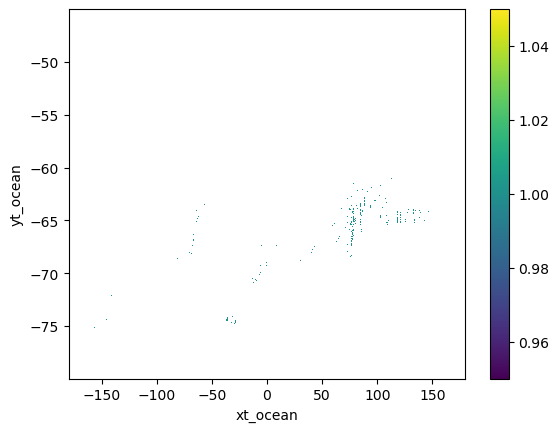

In [189]:
#Mask for all values - Merging datasets by coordinates
mask_all = grid_all_vals.merge(unique_crab_all, on = ['yt_ocean', 'xt_ocean'], how = 'left')

#Creating a data array using the original grid as an example
mask_all = xr.DataArray(mask_all.presence.values.reshape(grid_all.shape), 
                        dims = ['yt_ocean', 'xt_ocean'],
                        coords = {'yt_ocean': grid_all.yt_ocean.values, 
                                  'xt_ocean': grid_all.xt_ocean.values})
mask_all.plot()

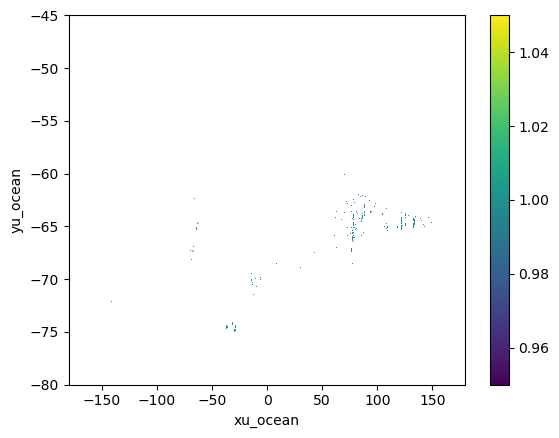

In [190]:
#Mask for all values - Merging datasets by coordinates
mask_vel = grid_vel_vals.merge(unique_crab_vel, on = ['yu_ocean', 'xu_ocean'], how = 'left')

#Creating a data array using the original grid as an example
mask_vel = xr.DataArray(mask_vel.presence.values.reshape(grid_vel.shape), 
                        dims = ['yu_ocean', 'xu_ocean'],
                        coords = {'yu_ocean': grid_vel.yu_ocean.values, 
                                  'xu_ocean': grid_vel.xu_ocean.values})
mask_vel.plot()

## Saving masks

In [191]:
mask_all.to_netcdf('/g/data/v45/la6889/Chapter2_Crabeaters/mask_crabeater_obs_ocean_grid.nc')
mask_vel.to_netcdf('/g/data/v45/la6889/Chapter2_Crabeaters/mask_crabeater_obs_vel_grid.nc')